# Check The Ranking Quality

In [1]:
# standard imports
import numpy as np
import os

# plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

# data management
import pandas as pd

# import optimizer
from scipy.optimize import curve_fit

# standard scrapers
import hittingpredictor as hp
import pitchingpredictor as pp



In [2]:
# set up the comparator
def gaussian(x, a, mu,sigma, c):
    """simple gaussian"""
    return a * np.exp(-1.*(x-mu)**2./sigma**2.) + c

In [3]:
# load the predictions for the 2019 season
BattingProjections2019 = np.genfromtxt('2019Predictions/batter_predictions021819.csv',\
                  dtype=[('Name','S20'),('PA','i4'),('AVG','f4'),('eAVG','f4'),\
                        ('HR','i4'),('eHR','i4'),('R','i4'),('eR','i4'),\
                        ('RBI','i4'),('eRBI','i4'),('SB','i4'),('eSB','i4'),\
                        ('Rank','i4')],\
                  delimiter=',',skip_header=1)

PitchingProjections2019 = np.genfromtxt('2019Predictions/pitcher_predictions020819.csv',\
                 dtype=[('Name','S20'),('IP','i4'),('SO','i4'),('eSO','i4'),\
                        ('ERA','f4'),('eERA','f4'),('WHIP','f4'),('eWHIP','f4'),\
                        ('W','i4'),('eW','i4'),('S','i4'),('eS','i4'),\
                        ('Rank','i4')],\
                  delimiter=',',skip_header=1)



In [4]:
# load 2019 statistics
Batting2019 = hp.scrape_year(year='2019',cat='bat',verbose=0)
Pitching2019 = pp.scrape_year(year='2019',cat='pit',verbose=0)



In [5]:
# clean up two pitching categories
Pitching2019['WHIP'] = (Pitching2019['BB'].astype('float')+Pitching2019['H'].astype('float'))/(Pitching2019['IP'].astype('float')+.1)
Pitching2019['S'] = Pitching2019['SV']



In [6]:
# definitions to match the results

def match_hitting_results(pl,RealStats,ProjectedStats):
    '''match the results from the hitting year, return sigmas
    
    certain categories must match in name...
    '''
    plr = np.where(RealStats['Name']==pl)[0][0]
    plp = np.where(np.array([x.decode().rstrip() for x in ProjectedStats['Name']])==pl)[0][0]

    compstats = ['AVG','HR','R','RBI','SB']
    
    sigmas = np.zeros(len(compstats))
    
    for istat,stat in enumerate(compstats):
        sigmas[istat] = (float(RealStats[stat][plr])-float(ProjectedStats[stat][plp]))/float(ProjectedStats['e'+stat][plp])
        
    return sigmas
    


def match_pitching_results(pl,RealStats,ProjectedStats):
    '''match the results from the hitting year, return sigmas
    
    certain categories must match in name...
    '''
    plr = np.where(RealStats['Name']==pl)[0][0]
    plp = np.where(np.array([x.decode().rstrip() for x in ProjectedStats['Name']])==pl)[0][0]

    compstats = ['ERA','WHIP','S','W','SO']
        
    sigmas = np.zeros(len(compstats))
    
    for istat,stat in enumerate(compstats):
        sigmas[istat] = (float(RealStats[stat][plr])-float(ProjectedStats[stat][plp]))/float(ProjectedStats['e'+stat][plp]+0.001)
        
    return sigmas
    




## Part 1: Hitters

In [7]:

nplayers = len(BattingProjections2019['Name'])
sigma_stats = np.zeros([nplayers,5])

for pl in range(0,nplayers):

    try:
        sigmas = match_hitting_results(BattingProjections2019['Name'][pl].decode().rstrip(),Batting2019,BattingProjections2019)
        sigma_stats[pl] = np.array(sigmas)
    except:
        #print('Failed for ',BattingProjections2019['Name'][pl].decode().rstrip())
        sigma_stats[pl] = np.array([np.nan,np.nan,np.nan,np.nan,np.nan])


Mean= -0.20490130856936728 Sigma= 1.233790942407728
Mean= 0.3512337645656141 Sigma= 3.360712695950445
Mean= -0.06274611954268117 Sigma= 4.55766286709475
Mean= 0.11522542408051625 Sigma= 5.01718055764608
Mean= -0.7162619223452049 Sigma= 1.5991924168912848


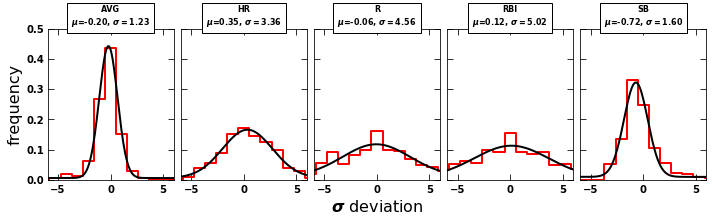

In [8]:
# how can we check the uncertainties?
# check how many sigma off we are on average

stats = ['AVG','HR','R','RBI','SB']




fig = plt.figure(figsize=(10,3))

PDict = {}
for istat,stat in enumerate(stats):

    dx = 0.175
    xstart = istat*(dx+0.01)+0.06
    ax = fig.add_axes([xstart,0.2,dx,0.7])

    a,b = np.histogram(sigma_stats[:,istat],bins=np.linspace(-9.,9.,18))

    popt, pcov = curve_fit(gaussian,b[0:-1]+0.5*(b[1]-b[0]),a/np.sum(a))
    print('Mean=',popt[1],'Sigma=',popt[2])

    ax.plot(b[0:-1]+0.5*(b[1]-b[0]),a/np.sum(a),color='red',drawstyle='steps-mid')

    xvals = np.linspace(b[0]+0.5*(b[1]-b[0]),b[-1]+0.5*(b[1]-b[0]),200)
    ax.plot(xvals,gaussian(xvals,*popt),color='black')

    ax.text(0.,0.5,'{0}\n$\mu$={1:3.2f}, $\sigma=${2:3.2f}'.format(stat,popt[1],popt[2]),\
            color='black',ha='center',va='bottom',bbox=dict(facecolor='white', alpha=1.0),size=8)

    if istat==2:
        ax.set_xlabel('$\sigma$ deviation',size=16)
        
    if istat==0:
        ax.set_ylabel('frequency',size=16)
    else:
        ax.set_yticklabels(())
        
    ax.tick_params(axis="y",which='both',direction="in")
    ax.tick_params(axis="x",which='both',direction="in",pad=5)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')

    ax.axis([-6.,6.,0.,0.5])


#plt.savefig('/Users/mpetersen/Desktop/battingpredictions.png',dpi=300)

## Part 2: Evaluate Pitchers

In [9]:

nplayers = len(PitchingProjections2019['Name'])
sigma_stats = np.zeros([nplayers,5])

for pl in range(0,nplayers):

    try:
        sigmas = match_pitching_results(PitchingProjections2019['Name'][pl].decode().rstrip(),Pitching2019,PitchingProjections2019)
        sigma_stats[pl] = np.array(sigmas)
    except:
        # print if diagnostic desired
        #print('Failed for ',PitchingProjections2019['Name'][pl].decode().rstrip())
        sigma_stats[pl] = np.array([np.nan,np.nan,np.nan,np.nan,np.nan])



Mean= 0.31994778981060684 Sigma= 2.3728706285464045
Mean= 0.03447836070133934 Sigma= 1.4454428249289804
Mean= 0.20707750535669625 Sigma= -0.3087439688788339
Mean= 0.2675664603296404 Sigma= 0.917032487687391
Mean= -0.4171754784339829 Sigma= 4.745772448645458


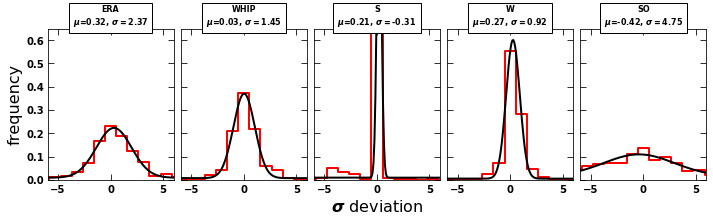

In [10]:
# how can we check the uncertainties?
# check how many sigma off we are on average

stats = ['ERA','WHIP','S','W','SO']




fig = plt.figure(figsize=(10,3))

PDict = {}
for istat,stat in enumerate(stats):

    dx = 0.175
    xstart = istat*(dx+0.01)+0.06
    ax = fig.add_axes([xstart,0.2,dx,0.7])

    a,b = np.histogram(sigma_stats[:,istat],bins=np.linspace(-9.,9.,18))

    popt, pcov = curve_fit(gaussian,b[0:-1]+0.5*(b[1]-b[0]),a/np.sum(a))
    print('Mean=',popt[1],'Sigma=',popt[2])

    ax.plot(b[0:-1]+0.5*(b[1]-b[0]),a/np.sum(a),color='red',drawstyle='steps-mid')

    xvals = np.linspace(b[0]+0.5*(b[1]-b[0]),b[-1]+0.5*(b[1]-b[0]),200)
    ax.plot(xvals,gaussian(xvals,*popt),color='black')

    ax.text(0.,0.65,'{0}\n$\mu$={1:3.2f}, $\sigma=${2:3.2f}'.format(stat,popt[1],popt[2]),\
            color='black',ha='center',va='bottom',bbox=dict(facecolor='white', alpha=1.0),size=8)

    if istat==2:
        ax.set_xlabel('$\sigma$ deviation',size=16)
        
    if istat==0:
        ax.set_ylabel('frequency',size=16)
    else:
        ax.set_yticklabels(())
        
    ax.tick_params(axis="y",which='both',direction="in")
    ax.tick_params(axis="x",which='both',direction="in",pad=5)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')

    ax.axis([-6.,6.,0.,0.65])


#plt.savefig('/Users/mpetersen/Desktop/battingpredictions.png',dpi=300)